# Python Assignment 4: Opt-out

Author: Sherry You </br>
Student Number: 1005990849

This assignment explores COVID-19 data using the ArcGIS for python API developed by ESRI.

---

# READ ME
---

## Documentation

Before exploring the data, I created some functions to reduce repetition in my code. There five main functions: `log errors()`, `get_boundaries()`, `curate_imported()`, `left_merge()`, `create map()`.

In addition to the five functions, I also created a server class to create a connection to the ArcGIS API, called `Server`.

### Functions
---

***log errors()*** </br>
This function takes the error that was caught from the exception and logs the error onto an error file called `errors_log`. The function records the date-time that the error occured, along with the recorded timestamp and description of the error and logs it onto the errors file. 

The function uses the `time`, `datetime` and `logging` modules in python. 

---

***get_boundaries()*** </br>
This function retrieves geographic data, or shape data from the GIS server. It finds the item using a given `item_id` then retrieves the feature layer containing the data from the GIS server. The function then returns a dataframe containing the feature layer data. If the response to the GIS server has timed out, the function will reconnect the user to the GIS server. 

The function uses the `time`, `datetime`, `logging`, `GIS` and `FeatureLayer` modules in python. 

---

***curate_imported()*** </br>
This function imports data into a dataframe given the title of the csv file. Then the function checks whether there are any null values in the dataframe. If there are null values, the function will display the rows containing the null values and asks the user whether or not they want to drop the rows with null values. If the user says 'y' for 'yes', then all rows with null values will be dropped and the resulting dataframe is returned. Otherwise, the original dataframe with the null values will be returned. 

The function uses the `pandas` and `display` modules in python.

---
***left_merge()*** </br>
This function merges two dataframes based on a given merge key, then prints the number of rows for all dataframes, pre and post merge. 

This function uses the `pandas` module in python.

---
***create_map()*** </br>
This function creates a map widget using the GIS, and maps the chosen attribute data from the given dataframe containing both attribute and geographical data. If the response to the GIS server has timed out, the function will reconnect the user to the GIS server. 

The function uses the `logging`, `time`, `GIS`, `pandas` and `matplotlib.pyplot` modules in python. 

### Classes
---
***Server*** </br>
The Server class is created to represent a GIS server. The class has attributes which save the `c_ID`, client_id, and `URL` of the user. The method, `connect_GIS()`, takes the `c_ID` and `URL` and uses it to create a connection to the GIS server. This method also issues a User Warning if the time it takes to secure a connection to the GIS server exceeds 5 seconds and logs the time it takes to connect onto the time log file called `time_log`.

This class uses the `logging`, `time`, `warnings` and `GIS` modules in python.

---

### External Library Package Versions
---
The versions of the external library packages can be found below:

In [1]:
!pip list

Package                   Version
------------------------- -----------------
anyio                     4.0.0
arcgis                    2.1.0.3
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
arrow                     1.2.3
asttokens                 2.0.5
attrs                     22.1.0
backcall                  0.2.0
beautifulsoup4            4.12.2
bleach                    4.1.0
blinker                   1.4
bokeh                     3.2.1
Bottleneck                1.3.5
brotlipy                  0.7.0
cachetools                4.2.2
certifi                   2023.7.22
cffi                      1.15.1
charset-normalizer        2.0.4
click                     8.0.4
cloudpickle               2.2.1
colorama                  0.4.6
comm                      0.1.2
contourpy                 1.0.5
cryptography              41.0.3
cycler                    0.11.0
cytoolz                   0.12.0
dask                      2023.6.0
debugpy                   1.6.7
decorator  

# Assignment Code

### Imports

In [2]:
# Imports
import sys, traceback, logging, time, warnings
from arcgis.gis import GIS
from arcgis.features import FeatureLayer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import display

# Create an Errors and Time Log file

In [3]:
# Create a file to log errors that occur in the notebook
try:
    errors_log = open('errors_log.txt', 'x')
except FileExistsError:
    errors_log = open('errors_log.txt', 'w')

In [4]:
# Create a function to log errors when exceptions occur
def log_errors(e):
    """ Writes e into errors_log file
        
        Parameters:
            e: the recorded error
            
        Returns:
            None  
    """ 
    global errors_log
    
    # Get the current time for the record
    ct = datetime.now()
    ct_out = 'Current_time: ' + str(ct) + "\n" 
    
    # Get the timestamp for the redc
    ts = ct.timestamp()
    ts_out = 'Timestamp: ' + str(ts) + "\n"
    
    # Store the error as a string
    error = str(e)
    er_out = 'Error: ' + error + "\n"
    
    # Log errors into error log file
    errors_log = open('errors_log.txt', 'a')
        
    # Write error into file
    errors_log.writelines([ct_out, ts_out, er_out])

    # Close errors log file
    errors_log.close()

In [5]:
# Create a file to log the time it takes to connect to GIS server
try:
    time_log = open('time_log.txt', 'x')
except FileExistsError:
    time_log = open('time_log.txt', 'w')

# Create a Connection to GIS Server

In [6]:
# Create a Server Class to store the connect to the GIS server
class Server:
    """
        A class to represent a GIS server.
        
        Attributes
            c_ID: str
                Client ID to connect to GIS server
            URL: str
                URL given to connect to GIS server
        
        Methods
            connect_gis(self):
                Creates a GIS connection using client ID and URL
        
    """
    def __init__(self, c_ID, URL):
        """ Initializes Server class variables given c_ID, and URL
        
            Parameters:
                c_ID (str): Client ID
                URL (str): URL for GIS
        """
        self.c_ID = c_ID
        self.URL = URL
        
    def connect_GIS(self):
        """ Returns an arcgis.gis.GIS object and connects client to the GIS API using the client_id and 
            a given URL for the GIS Server.
            
            Returns
                gis (arcgis.gis.GIS): GIS connection
            
        """
        global time_log
        # Record the start time before we connect to server
        start_time = time.time()
        
        # Connect to the GIS server
        gis = GIS(self.URL, client_id = self.c_ID, verify_cert=False)
        
        # Get the date time for the connection
        dt = datetime.now()
        dt_out = 'Current_time: ' + str(dt) + "\n"
        
        # Determine the connection time 
        connection_time = time.time() - start_time
        ct_out = "Connection time: " + str(connection_time) + "\n"
        
        # Log connection time into time_log file
        time_log = open('time_log.txt', 'a')

        # Write error into file
        time_log.writelines([dt_out, ct_out])

        # Close errors log file
        time_log.close()
        
        # Raise a warning if the connection time is greater than 5 seconds
        if connection_time > 5:
            warnings.warn("Connection time to GIS server exceeded 5 seconds. Please copy paste the OAuth2 Approval code quicker.")

        # Show Login Results
        print("Successfully logged in as: " + gis.properties.user.username)

        return gis

# Connect to GIS Server

Create a connection to GIS server using my client-id and URL.

In [7]:
# Store the client ID for the GIS server
c_ID = "nI8t732ur93fhB4M"

In [8]:
# Store the URL for GIS server
URL = "https://utoronto.maps.arcgis.com"

In [9]:
# Create a Server Object
server = Server(c_ID, URL)

In [10]:
# Create a gis connection
gis = server.connect_GIS()

Setting `verify_cert` to False is a security risk, use at your own risk.


Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://utoronto.maps.arcgis.com/sharing/rest/oauth2/authorize?response_type=code&client_id=nI8t732ur93fhB4M&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=wfXuuGMrINk2wRWfRRluvUfW2hwPTP&allow_verification=false
Enter code obtained on signing in using SAML: ········
Successfully logged in as: yousherr_utoronto


C:\Users\syou1\AppData\Local\Temp\ipykernel_9348\2358919196.py:61: UserWarning: Connection time to GIS server exceeded 5 seconds. Please copy paste the OAuth2 Approval code quicker.
  warnings.warn("Connection time to GIS server exceeded 5 seconds. Please copy paste the OAuth2 Approval code quicker.")


# Data Curation Functions

In [11]:
def get_boundaries(item_id):
    """ Returns a dataframe with boundary data given item_id
        
        Parameters:
            item_id (str): ID of item on GIS server
        
        Returns:
            boundary_df (DataFrame): A dataframe containing data on the item
    """
    global gis
    try:
        item = gis.content.get(item_id)
    
    except Exception as e:      
        # Log errors into errors_log
        log_errors(e)
        
        # Reconnect to GIS server
        gis = server.connect_GIS()
    
    finally:
        item = gis.content.get(item_id)
        item_flayer = item.layers[0]
        boundary_df = item_flayer.query(as_df=True)
        return boundary_df

In [12]:
# Create a function to curate imported data
def curate_imported(csv_file):
    """ Return a dataframe containing curated data given the csv_file
    
        Parameters:
            csv_file (str): Title of csv file
            
        Returns:
            data (DataFrame): Dataframe containing data from the csv file
    """
    # Import the data
    data = pd.read_csv(csv_file)
    
    # Check to see if there are any null values
    has_nulls = data.isnull().values.any()
    
    # If there is nulls, show rows with nulls
    if has_nulls:
        print("The following rows contain null values: \n")
        nulls =  data.isnull().any(axis=1)
        df_nulls = data[nulls]
        display(df_nulls)
        
        ask = True
        while ask:
            # Ask user if they want to drop null rows
            drop_nulls = input("Do you want to drop rows with null values? [y/n]")

            # Drop rows with nulls if user says 'y'
            if drop_nulls == 'y':
                data = data.dropna()
                return data
            elif drop_nulls == 'n':
                return data
            else:
                print("Invalid response. Please type 'y' or 'n'.")

In [13]:
# Create a function to merge attribute data and geographical data
def left_merge(left_df, right_df, merge_key):
    """ Return a dataframe containing the left_df and the right_df merged on the merge_key
    
        Parameters:
            left_df (DataFrame): The left dataframe to merge
            right_df (DataFrame): The right dataframe to merge
            merge_key (str/List of strings): The key to merge the two dataframes on
        
        Returns:
            final_df (DataFrame): A dataframe containing the merged dataframes based on merge_key
    """
    # Store the number of observations in left and right dataframes
    pre_left = len(left_df)
    pre_right = len(right_df)
    
    # Merge the left and right dataframes to a final dataframe
    final_df = left_df.merge(right_df, how='left', on=merge_key)
    
    # Record the number of records in the merged dataframe 
    post_rows = len(final_df)
    
    # Display pre and post-join record counts
    print("Num rows in left pre-merge: ", pre_left)
    print("Num rows in right pre-merge: ", pre_right)
    print("Num rows in merged dataframe: ", post_rows)
    
    return final_df

# Create Map Function

In [14]:
# Create a function to map the data
def create_map(data, rend_type, classify_col, **kwargs):
    """ Returns a map given data, rend_type, classify_col, with optional colour palette from colours
        
        Parameters:
            data (DataFrame): Dataframe containing attribute and shape data
            rend_type (str): the render type for the map
            classify_col (str): the attribute to classify and visualize on the map
            **kwargs: Additional parameters to pass into create_map
            
        Returns:
            m_widget (arcgis.widgets._mapview._mapview.MapView): Map visualizing attribute data
    
    """
    
    # Get optional arguments if defined
    c_count = kwargs.get('c_count', 7)
    c_algo = kwargs.get('c_algo', 'esriClassifyNaturalBreaks')
    colours = kwargs.get('colours', 'inferno')
    
    global gis
    
    try:
        # Create a map widget
        m_widget = gis.map()
    except TypeError as te:
        # Reconnect to server
        gis = server.connect_GIS()
        # Log error to error file
        log_errors(te)
    finally:
        m_widget = gis.map()
    
    # Check to see which render type to map
    if rend_type == 'c':
        try:
            data.spatial.plot(kind='map', map_widget=m_widget, 
                                  renderer_type='c', 
                                  method=c_algo, # classification algorithm
                                  class_count=c_count,  # choose the number of classes
                                  col=classify_col,  # numeric column to classify
                                  cmap=colours,  # color map to pick colors from for each class
                                  alpha=0.7  # specify opacity
                                 )
        except AttributeError as ae:
            # Fix attribute error
            np.int = np.int_
            # Log errors into errors_log
            log_errors(ae)      
            
        finally:
            data.spatial.plot(kind='map', map_widget=m_widget, 
                                  renderer_type='c', 
                                  method=c_algo,  # classification algorithm
                                  class_count=c_count,  # choose the number of classes
                                  col=classify_col,  # numeric column to classify
                                  cmap=colours,  # color map to pick colors from for each class
                                  alpha=0.7  # specify opacity
                                 )
    elif rend_type == 'u':
        try:
            data.spatial.plot(kind='map', map_widget=m_widget, renderer_type='u', col=classify_col)
        except AttributeError as ae:
            # Fix error
            np.int=np.int_
            # Log errors into errors_log
            log_errors(ae) 
        finally:
            data.spatial.plot(kind='map', map_widget=m_widget, renderer_type='u', col=classify_col)
    
    m_widget.legend=True
    
    return m_widget

# Import Data US School Closure Data

Data on US school closures by state can be found here:
https://www.edweek.org/data-coronavirus-and-school-closures-in-2019-2020/2021/12

Note: When prompted whether or not the user wants to drop null values, I inputed 'n', for no.

In [15]:
# Import US closure data
US_closures = curate_imported("school_closures.csv")

The following rows contain null values: 



,"May 15, 2020, 6:30 p.m. ET",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
3,American Samoa,AS,State ordered closure,Ordered closed until further notice,2020-03-23,NaN,28,NaN
6,Bureau of Indian Education,BIE,Closures determined at school/district levels,Varies by school/district,NaN,NaN,174,"45,399"
31,Montana,MT,Closure expired,Varies by school/district,2020-03-16,NaN,820,"146,375"
40,Northern Marianas\t,MP,State ordered closure,Ordered closed for the academic year,2020-03-17,2020-03-17,NaN,NaN
58,Wyoming,WY,Closure expired,Varies by school/district,2020-03-16,NaN,371,"94,170"


Do you want to drop rows with null values? [y/n]n


In [16]:
# Show the first five rows of the dataframe
US_closures.head()

,"May 15, 2020, 6:30 p.m. ET",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,State,State Abbreviation,State Status,State Closure Status,State Closure Start Date,Date closed for the academic year,State Number of Public Schools,State Public School Enrollment
1,Alabama,AL,State ordered closure,Ordered closed for the academic year,2020-03-19,2020-04-06,"1,513","744,930"
2,Alaska,AK,State ordered closure,Ordered closed for the academic year,2020-03-16,2020-04-09,507,"132,737"
3,American Samoa,AS,State ordered closure,Ordered closed until further notice,2020-03-23,NaN,28,NaN
4,Arizona,AZ,State ordered closure,Ordered closed for the academic year,2020-03-16,2020-03-30,"2,308","1,123,137"


In [17]:
# Get all values of the first row, which we will use to replace the column names
col_names = US_closures.loc[:0,].values[0]
col_names

array(['State', 'State Abbreviation', 'State Status',
       'State Closure Status', 'State Closure Start Date',
       'Date closed for the academic year',
       'State Number of Public Schools', 'State Public School Enrollment'],
      dtype=object)

In [18]:
# Drop the first row from the dataframe
US_closures = US_closures.drop(0)

In [19]:
# Reappend the column names
US_closures = US_closures.set_axis(col_names, axis=1)

In [20]:
# Drop columns we are not interested in
US_closures = US_closures.drop(columns=['State Number of Public Schools', 'State Public School Enrollment'])

In [21]:
# Convert date columns to datetime type
US_closures['State Closure Start Date'] = pd.to_datetime(US_closures['State Closure Start Date'])
US_closures['Date closed for the academic year'] = pd.to_datetime(US_closures['Date closed for the academic year'])

In [22]:
# Convert our categorical data on closure status to numeric data
US_closures['State Status #'] = US_closures['State Status'].replace({'Closure expired':1, 
                                                                     'Closures determined at school/district levels':2,
                                                                     'State recommended closure':3, 
                                                                     'State ordered closure':4})

US_closures['State Closure Status #'] = US_closures['State Closure Status'].replace({'Varies by school/district':1, 
                                                                                     'Recommended closed for the academic year':2,
                                                                                     'Ordered closed for the academic year':3,
                                                                                     'Ordered closed until further notice':4})

In [23]:
# Show resulting dataframe
US_closures.head()

,State,State Abbreviation,State Status,State Closure Status,State Closure Start Date,Date closed for the academic year,State Status #,State Closure Status #
1,Alabama,AL,State ordered closure,Ordered closed for the academic year,2020-03-19,2020-04-06,4,3
2,Alaska,AK,State ordered closure,Ordered closed for the academic year,2020-03-16,2020-04-09,4,3
3,American Samoa,AS,State ordered closure,Ordered closed until further notice,2020-03-23,NaT,4,4
4,Arizona,AZ,State ordered closure,Ordered closed for the academic year,2020-03-16,2020-03-30,4,3
5,Arkansas,AR,State ordered closure,Ordered closed for the academic year,2020-03-17,2020-04-06,4,3


In [24]:
# Show info about our data
US_closures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 1 to 58
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   State                              58 non-null     object        
 1   State Abbreviation                 58 non-null     object        
 2   State Status                       58 non-null     object        
 3   State Closure Status               58 non-null     object        
 4   State Closure Start Date           57 non-null     datetime64[ns]
 5   Date closed for the academic year  54 non-null     datetime64[ns]
 6   State Status #                     58 non-null     int64         
 7   State Closure Status #             58 non-null     int64         
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 3.8+ KB


### Import US State Boundaries Data

In [25]:
# Get data for US state boundaries
us_bounds = get_boundaries('99fd67933e754a1181cc755146be21ca')
us_bounds

,FID,STATE_NAME,STATE_FIPS,SUB_REGION,STATE_ABBR,POPULATION,POP_SQMI,POP2010,POP10_SQMI,WHITE,...,RENTER_OCC,NO_FARMS12,AVE_SIZE12,CROP_ACR12,AVE_SALE12,SQMI,Shape__Area,Shape__Length,GlobalID,SHAPE
0,1,Alaska,02,Pacific,AK,744733,1.3,710231,1.2,473576,...,95293,762.0,1094.0,84114.0,77329.0,581369.17,8101401247192.650391,59249543.508505,caa768f1-67c4-4e4e-be1f-585897d5d651,"{""rings"": [[[-17959594.8053098, 8122953.575198..."
1,2,California,06,Pacific,CA,39611295,250.5,37253956,235.6,21453934,...,5542127,77857.0,328.0,9591783.0,547510.0,158144.83,647979886894.31604,5237952.377098,1b72b84f-ab21-4f2c-abf1-d6029e20e2b9,"{""rings"": [[[-13543710.3257494, 4603367.827345..."
2,3,Hawaii,15,Pacific,HI,1461211,227.3,1360301,211.6,336599,...,192656,7000.0,161.0,174042.0,94478.0,6429.38,18880665255.351601,1370185.236623,63de8c01-6a03-4f45-8647-fb3b846a9906,"{""rings"": [[[-17819334.303422, 2512026.7784964..."
3,4,Idaho,16,Mountain,ID,1714694,20.5,1567582,18.8,1396487,...,174505,24816.0,474.0,5793347.0,314372.0,83570.14,423521380007.620972,3858889.212865,b13b05e7-ac98-4da2-81d1-b1f302ab8dda,"{""rings"": [[[-13027307.5891034, 5415905.134774..."
4,5,Nevada,32,Mountain,NV,2994047,27.1,2700551,24.4,1786688,...,414770,4137.0,1429.0,756852.0,184710.0,110561.37,480710125514.065979,3025638.815004,c442ca59-4d9c-4eee-8170-e1d436ff0cb4,"{""rings"": [[[-13263990.1054907, 4637763.931898..."
5,6,Oregon,41,Pacific,OR,4122334,42.5,3831074,39.5,3204614,...,574453,35439.0,460.0,4690420.0,137805.0,97076.81,485303511185.315979,3152829.235599,30d7af58-27ed-46f6-99ad-8a8135041750,"{""rings"": [[[-13518806.9335409, 5160130.819824..."
6,7,Washington,53,Pacific,WA,7311450,108.1,6724540,99.4,5196362,...,946156,37249.0,396.0,7526742.0,244859.0,67620.68,379885502540.609009,4578373.23123,03626501-c742-48c1-8047-db7dc135b862,"{""rings"": [[[-13625730.0473505, 6144404.969188..."
7,8,Arizona,04,Mountain,AZ,7031568,61.7,6392017,56.1,4667121,...,809303,20005.0,1312.0,1150811.0,186559.0,113997.77,433153359475.22699,2831600.60119,f95332ad-007b-4f65-9450-401d225e5bc2,"{""rings"": [[[-12748377.9624272, 3898982.234195..."
8,9,Arkansas,05,West South Central,AR,3041640,57.2,2915918,54.8,2245229,...,378928,45071.0,306.0,7931111.0,216897.0,53178.77,204294428990.359009,2514666.060031,acf9651a-ac7a-4fff-92d2-fcb1d3ebddfb,"{""rings"": [[[-10515427.3833416, 4055253.487021..."
9,10,Colorado,08,Mountain,CO,5594670,53.7,5029196,48.3,4089202,...,679768,36180.0,881.0,10649747.0,215060.0,104093.95,447332326993.492004,2708162.62172,01ab8a9e-566a-41ec-8dc4-8d76dfea5639,"{""rings"": [[[-11359536.8690666, 4528901.215572..."


### Merge School Closure Data and Boundaries Data

In [26]:
# Rename columns in boundary data
us_bounds = us_bounds.rename(columns={'STATE_NAME':'State', 'STATE_ABBR':'State Abbreviation'})

In [27]:
# Merge the attribute and geographical data
us_data = left_merge(us_bounds, US_closures, ['State', 'State Abbreviation'])

Num rows in left pre-merge:  51
Num rows in right pre-merge:  58
Num rows in merged dataframe:  51


In [28]:
# Keep only the columns we are interested in
us_data = us_data[['State', 'State Abbreviation', 'Shape__Area', 'Shape__Length', 
                   'GlobalID', 'SHAPE', 'State Status','State Closure Status', 
                   'State Closure Start Date', 'Date closed for the academic year']]

us_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   State                              51 non-null     object        
 1   State Abbreviation                 51 non-null     object        
 2   Shape__Area                        51 non-null     Float64       
 3   Shape__Length                      51 non-null     Float64       
 4   GlobalID                           51 non-null     string        
 5   SHAPE                              51 non-null     geometry      
 6   State Status                       51 non-null     object        
 7   State Closure Status               51 non-null     object        
 8   State Closure Start Date           51 non-null     datetime64[ns]
 9   Date closed for the academic year  49 non-null     datetime64[ns]
dtypes: Float64(2), datetime64[ns](2), geomet

# Map US Closures by State

In [29]:
close_map = create_map(us_data, 'u', 'State_Status')
close_map

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [30]:
# Zoom in closer on the map
close_map.zoom = 4

## Get COVID Data

From the sample found at:
https://developers.arcgis.com/python/samples/covid19-part1-mapping-the-pandemic/#2-map-the-covid-19-cases-in-china, we can also add another layer from GIS server onto our map.

<Item title:"Coronavirus COVID-19 (2019-nCoV)" type:Dashboard owner:CSSE_covid19>
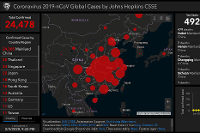

In [31]:
item = gis.content.search("Coronavirus_2019_nCoV_Cases owner:CSSE_covid19", outside_org=True)[0]
item

In [32]:
src_url = "https://services1.arcgis.com/0MSEUqKaxRlEPj5g/arcgis/rest/services/Coronavirus_2019_nCoV_Cases/FeatureServer/1"
fl = FeatureLayer(url=src_url)

In [33]:
df_global = fl.query(where="1=1",
                     return_geometry=True,
                     as_df=True)

C:\Users\syou1\anaconda3\envs\arcgis_env\lib\site-packages\arcgis\features\layer.py:3782: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[fld] = pd.to_datetime(
C:\Users\syou1\anaconda3\envs\arcgis_env\lib\site-packages\arcgis\features\layer.py:2310: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[fld] = pd.to_datetime(


In [34]:
df_global

,OBJECTID,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Recovered,Deaths,Active,Admin2,FIPS,Combined_Key,SHAPE
0,1,<NA>,Afghanistan,2022-09-11 05:20:45,33.93911,67.709953,195631,0,7787,0,<NA>,<NA>,Afghanistan,"{""x"": 67.70995300000004, ""y"": 33.9391100000000..."
1,2,<NA>,Albania,2022-09-11 05:20:45,41.1533,20.1683,330948,0,3584,0,<NA>,<NA>,Albania,"{""x"": 20.168300000000045, ""y"": 41.153300000000..."
2,3,<NA>,Algeria,2022-09-11 05:20:45,28.0339,1.6596,270532,0,6879,0,<NA>,<NA>,Algeria,"{""x"": 1.6596000000000686, ""y"": 28.033900000000..."
3,4,<NA>,Andorra,2022-09-11 05:20:45,42.5063,1.5218,46113,0,155,0,<NA>,<NA>,Andorra,"{""x"": 1.5218000000000416, ""y"": 42.506300000000..."
4,5,<NA>,Angola,2022-09-11 05:20:45,-11.2027,17.8739,103131,0,1917,0,<NA>,<NA>,Angola,"{""x"": 17.87390000000005, ""y"": -11.202699999999..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,789,Ohio,US,2022-09-11 05:20:45,40.388783,-82.764915,3096557,0,39576,0,<NA>,39,"Ohio, US","{""x"": -82.76491499999997, ""y"": 40.388783000000..."
789,790,Alabama,US,2022-09-11 05:20:45,32.3182,-86.9023,1504180,0,20239,0,<NA>,01,"Alabama, US","{""x"": -86.90229999999997, ""y"": 32.318200000000..."
790,791,North Carolina,US,2022-09-11 05:20:45,35.630066,-79.806419,3141302,0,26365,0,<NA>,37,"North Carolina, US","{""x"": -79.80641899999995, ""y"": 35.630066000000..."
791,792,District of Columbia,US,2022-09-11 05:20:45,38.897438,-77.026817,166893,0,1382,0,<NA>,11,"District of Columbia, US","{""x"": -77.02681699999994, ""y"": 38.897438000000..."


In [35]:
# Add an additional layer to close-map displaying the COVID statistics
close_map.add_layer(fl, { "type": "FeatureLayer",
                     "renderer":"ClassedSizeRenderer",
                     "field_name":"Confirmed"})

In [36]:
close_map

MapView(jupyter_target='notebook', layout=Layout(height='400px', width='100%'), legend=True, ready=True)

In [37]:
# Zoom in closer on the map
close_map.zoom = 4

# Import Global COVID-19 Cases

The data below was retrieved from Our World in Data at https://ourworldindata.org/coronavirus.
Note: When prompted to drop nulls, I responded with 'n', for no.

In [38]:
# Import data on global daily COVID cases
daily_cases = curate_imported("daily-cases.csv")

The following rows contain null values: 



,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
327,12/01/2020,12,1,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,NaN
328,11/01/2020,11,1,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,NaN
329,10/01/2020,10,1,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,NaN
330,09/01/2020,9,1,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,NaN
331,08/01/2020,8,1,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
61895,25/03/2020,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
61896,24/03/2020,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
61897,23/03/2020,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
61898,22/03/2020,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN


Do you want to drop rows with null values? [y/n]n


In [39]:
# Show info about the dataset
daily_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61900 entries, 0 to 61899
Data columns (total 12 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   dateRep                                                     61900 non-null  object 
 1   day                                                         61900 non-null  int64  
 2   month                                                       61900 non-null  int64  
 3   year                                                        61900 non-null  int64  
 4   cases                                                       61900 non-null  int64  
 5   deaths                                                      61900 non-null  int64  
 6   countriesAndTerritories                                     61900 non-null  object 
 7   geoId                                                       61625 non-null  object 
 

In [40]:
# Convert date to datetime 
daily_cases['dateRep'] = pd.to_datetime(daily_cases['dateRep'], dayfirst=True)

In [41]:
# Rename Columns
daily_cases = daily_cases.rename(columns={'countriesAndTerritories':'COUNTRY', 'geoId':'ISO'})

In [42]:
# Save the population data to a different dataframe
pop_2019 = daily_cases[['COUNTRY','ISO', 'popData2019']]
# Groupby Country and geoId 
pop_2019 = pop_2019.groupby(['COUNTRY', 'ISO']).mean().reset_index()
# Sow the population data 2019
pop_2019

,COUNTRY,ISO,popData2019
0,Afghanistan,AF,38041757.0
1,Albania,AL,2862427.0
2,Algeria,DZ,43053054.0
3,Andorra,AD,76177.0
4,Angola,AO,31825299.0
...,...,...,...
208,Wallis_and_Futuna,WF,NaN
209,Western_Sahara,EH,582458.0
210,Yemen,YE,29161922.0
211,Zambia,ZM,17861034.0


In [43]:
# Select the columns we are interested in for our cases data
cases_data = daily_cases[['COUNTRY','ISO','year', 'cases', 'deaths']]
# Show the first 5 results
cases_data.head()

,COUNTRY,ISO,year,cases,deaths
0,Afghanistan,AF,2020,746,6
1,Afghanistan,AF,2020,298,9
2,Afghanistan,AF,2020,113,11
3,Afghanistan,AF,2020,63,10
4,Afghanistan,AF,2020,202,16


In [44]:
# Since the data is currently recorded per day,
# group the data by country and year
gpby_year = cases_data.groupby(['COUNTRY', 'ISO','year']).sum().reset_index()

In [45]:
# Show the resulting dataframe
gpby_year

,COUNTRY,ISO,year,cases,deaths
0,Afghanistan,AF,2019,0,0
1,Afghanistan,AF,2020,49273,1971
2,Albania,AL,2020,48530,1003
3,Algeria,DZ,2019,0,0
4,Algeria,DZ,2020,92102,2596
...,...,...,...,...,...
275,Wallis_and_Futuna,WF,2020,3,0
276,Western_Sahara,EH,2020,766,1
277,Yemen,YE,2020,2083,606
278,Zambia,ZM,2020,18274,367


In [46]:
# Get Data for 2020
cases_2020 = gpby_year[gpby_year['year'] == 2020]
cases_2020

,COUNTRY,ISO,year,cases,deaths
1,Afghanistan,AF,2020,49273,1971
2,Albania,AL,2020,48530,1003
4,Algeria,DZ,2020,92102,2596
5,Andorra,AD,2020,7338,79
6,Angola,AO,2020,16188,371
...,...,...,...,...,...
275,Wallis_and_Futuna,WF,2020,3,0
276,Western_Sahara,EH,2020,766,1
277,Yemen,YE,2020,2083,606
278,Zambia,ZM,2020,18274,367


In [47]:
# Remove the "_" from the country names
cases_2020.loc[:,'COUNTRY'] = cases_2020.loc[:,'COUNTRY'].str.replace("_", " ")

In [48]:
# Merge the population data and the cases_2020 data
cases_2020 = left_merge(cases_2020, pop_2019, ['COUNTRY', 'ISO'])
cases_2020

Num rows in left pre-merge:  213
Num rows in right pre-merge:  213
Num rows in merged dataframe:  213


,COUNTRY,ISO,year,cases,deaths,popData2019
0,Afghanistan,AF,2020,49273,1971,38041757.0
1,Albania,AL,2020,48530,1003,2862427.0
2,Algeria,DZ,2020,92102,2596,43053054.0
3,Andorra,AD,2020,7338,79,76177.0
4,Angola,AO,2020,16188,371,31825299.0
...,...,...,...,...,...,...
208,Wallis and Futuna,WF,2020,3,0,NaN
209,Western Sahara,EH,2020,766,1,NaN
210,Yemen,YE,2020,2083,606,29161922.0
211,Zambia,ZM,2020,18274,367,17861034.0


In [49]:
# Create a new column that calculates the ratio of cases to population
# and a column that calculates the mortality rate for each country per 1000 people
cases_2020['Cases Rate per 1000'] = cases_2020['cases']/cases_2020['popData2019'] * 1000
cases_2020['Mortality Rate per 1000'] = cases_2020['deaths']/cases_2020['popData2019'] * 1000
cases_2020

,COUNTRY,ISO,year,cases,deaths,popData2019,Cases Rate per 1000,Mortality Rate per 1000
0,Afghanistan,AF,2020,49273,1971,38041757.0,1.295235,0.051811
1,Albania,AL,2020,48530,1003,2862427.0,16.954144,0.350402
2,Algeria,DZ,2020,92102,2596,43053054.0,2.139268,0.060298
3,Andorra,AD,2020,7338,79,76177.0,96.328288,1.037058
4,Angola,AO,2020,16188,371,31825299.0,0.508652,0.011657
...,...,...,...,...,...,...,...,...
208,Wallis and Futuna,WF,2020,3,0,NaN,NaN,NaN
209,Western Sahara,EH,2020,766,1,NaN,NaN,NaN
210,Yemen,YE,2020,2083,606,29161922.0,0.071429,0.020781
211,Zambia,ZM,2020,18274,367,17861034.0,1.023121,0.020548


In [50]:
# Get summary statistics
cases_2020.describe()

,year,cases,deaths,popData2019,Cases Rate per 1000,Mortality Rate per 1000
count,213.0,2.130000e+02,213.000000,1.620000e+02,162.000000,162.000000
mean,2020.0,3.356200e+05,7571.234742,4.215023e+07,14.945459,0.253843
std,0.0,1.419317e+06,28471.580547,1.584917e+08,17.429014,0.315946
min,2020.0,1.000000e+00,0.000000,4.991000e+03,0.003335,0.000000
25%,2020.0,1.807000e+03,32.000000,2.137095e+06,1.027803,0.016888
50%,2020.0,1.763800e+04,273.000000,9.386716e+06,8.123155,0.098755
75%,2020.0,1.471500e+05,2552.000000,2.902362e+07,25.325481,0.351616
max,2020.0,1.625675e+07,299177.000000,1.433784e+09,96.328288,1.567018


In [51]:
cases_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   COUNTRY                  213 non-null    object 
 1   ISO                      213 non-null    object 
 2   year                     213 non-null    int64  
 3   cases                    213 non-null    int64  
 4   deaths                   213 non-null    int64  
 5   popData2019              162 non-null    float64
 6   Cases Rate per 1000      162 non-null    float64
 7   Mortality Rate per 1000  162 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 13.4+ KB


# Data Visualizations

We can plot some histograms to get a better understanding of the distribution of our data.

<Axes: xlabel='Cases Rate per 1000', ylabel='Count'>

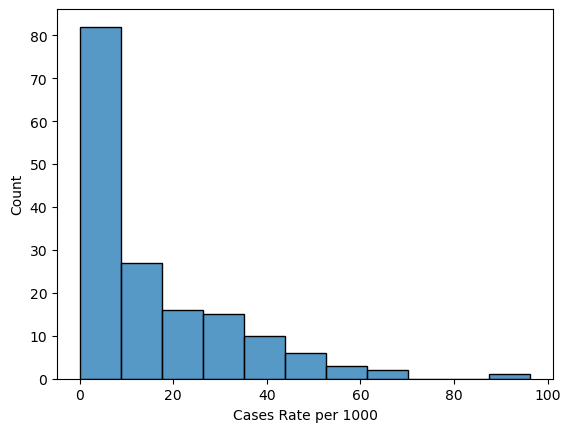

In [52]:
# Plot Cases Rate per 1000
sns.histplot(data=cases_2020, x = 'Cases Rate per 1000')

<Axes: xlabel='Mortality Rate per 1000', ylabel='Count'>

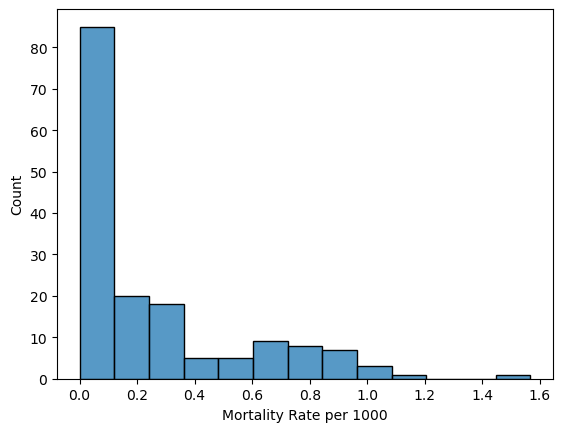

In [53]:
# Plot Mortality Rate per 1000
sns.histplot(data=cases_2020, x = 'Mortality Rate per 1000')

# Get World Map Boundaries

In [54]:
# Get boundaries for world map
countries_df = get_boundaries('2b93b06dc0dc4e809d3c8db5cb96ba69')
countries_df

,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,Shape__Area,Shape__Length,SHAPE
0,1,Afghanistan,AF,Afghanistan,AF,934649399856.968994,6110457.122002,"{""rings"": [[[6821274.81000371, 4246712.6102056..."
1,2,Albania,AL,Albania,AL,50586702997.128899,1271947.521774,"{""rings"": [[[2178614.504164, 5113950.86703724]..."
2,3,Algeria,DZ,Algeria,DZ,3014489452451.890137,8316048.958881,"{""rings"": [[[512443.030025741, 4423494.2467838..."
3,4,American Samoa,AS,United States,US,175458117.847656,67291.20231,"{""rings"": [[[-19007124.004548, -1617338.540375..."
4,5,Andorra,AD,Andorra,AD,934995585.44928,117137.526197,"{""rings"": [[[160949.742967772, 5251578.7469901..."
...,...,...,...,...,...,...,...,...
246,247,Vietnam,VN,Viet Nam,VN,357796185388.752014,7604244.348566,"{""rings"": [[[11919975.671198, 1933404.70295197..."
247,248,Wallis and Futuna,WF,France,FR,171168962.84375,79180.814978,"{""rings"": [[[-19821639.5932036, -1611402.11511..."
248,249,Yemen,YE,Yemen,YE,493572658266.801025,3840309.352632,"{""rings"": [[[5260340.77678493, 1530115.4381149..."
249,250,Zambia,ZM,Zambia,ZM,801072640637.453003,5538283.036938,"{""rings"": [[[3363297.78944308, -1687093.286636..."


In [55]:
# Merge the attribute data and the geographical data
country_data = left_merge(countries_df, cases_2020, 'ISO')

Num rows in left pre-merge:  251
Num rows in right pre-merge:  213
Num rows in merged dataframe:  251


In [56]:
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   FID                      251 non-null    Int64   
 1   COUNTRY_x                251 non-null    string  
 2   ISO                      251 non-null    object  
 3   COUNTRYAFF               251 non-null    string  
 4   AFF_ISO                  251 non-null    string  
 5   Shape__Area              251 non-null    Float64 
 6   Shape__Length            251 non-null    Float64 
 7   SHAPE                    251 non-null    geometry
 8   COUNTRY_y                212 non-null    object  
 9   year                     212 non-null    float64 
 10  cases                    212 non-null    float64 
 11  deaths                   212 non-null    float64 
 12  popData2019              164 non-null    float64 
 13  Cases Rate per 1000      164 non-null    float64 
 14  Mortality 

# Plot COVID data on World Map 

In [57]:
deaths_2020_map = create_map(country_data, 'c', 'deaths')
deaths_2020_map

MapView(layout=Layout(height='400px', width='100%'), legend=True)

---

# Future Improvements
---
Some suggestions for future improvements for this project include:
- Creating a get_times() function to get the datetime and timestamp for the errors or connection time
- Create a function to check fo nulls in dataframe
- Adjust the import_curated() function to also give users the choice to drop columns if there are many nulls found in a column
- Instead of the create_map() function, implement a MAP class which contains attributes related to the type of map and methods that help the user implement the gis map widget
    - Can create subclasses of the MAP to map different types of render types, for example, 'c', or 'u'
- Create more data visualizations other than histograms such as scatter plots
- Plot the Mortality Rates for each country instead of just deaths
    - Map plot would not classify the results into different bins so the resulting map ended up as only one colour

# Thank you for reading!